# Exploring the Movielens dataset with the Spark RDD API

## Install Spark Environment
Since we are not running on databricks, we will need to install Spark by ourselves, every time we run the session.  
We need to install Spark, as well as a Java Runtime Environment.  
Then we need to setup a few environment variables.  

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!curl -O https://dlcdn.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop3.2.tgz
!tar xf spark-3.2.3-bin-hadoop3.2.tgz
!pip install -q findspark

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  287M  100  287M    0     0   248M      0  0:00:01  0:00:01 --:--:--  248M


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop3.2"

In [6]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

## Optional step : Enable SparkUI through secure tunnel
This step is useful if you want to look at Spark UI.
First, you need to create a free ngrok account : https://dashboard.ngrok.com/login.  
Then connect on the website and copy your AuthToken.

In [7]:
# this step downloads ngrok, configures your AuthToken, then starts the tunnel
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
#!./ngrok authtoken my_ngrok_auth_token_retrieved_from_website # <-------------- change this line !
!./ngrok authtoken 25Pb4DqNqaoy5kCwimBO7dFMwvx_5BYL36GDSkQtRexvt9pRA
get_ipython().system_raw('./ngrok http 4050 &')

--2022-12-01 17:23:48--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 52.202.168.65, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  --.-KB/s    in 0.1s    

2022-12-01 17:23:48 (103 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## Other Imports

In [8]:
%matplotlib inline

import urllib
import urllib.request as req
import zipfile
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Downloading the dataset

In [9]:
url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist()
zip_file_object.extractall()

In [11]:
!ls

ml-20m			      spark-3.2.1-bin-hadoop3.2.tgz
ngrok			      spark-3.2.3-bin-hadoop3.2
ngrok-stable-linux-amd64.zip  spark-3.2.3-bin-hadoop3.2.tgz
sample_data


In [12]:
movies_path = "ml-20m/movies.csv"
ratings_path = "ml-20m/ratings.csv"

### Loading the data

Loading data with Spark Dataframe API.  
Loading a csv with the RDD API is not supported out of the box and is painful to implement.

In [13]:
ratings_df = spark.read.options(header=True, inferSchema=True).csv(ratings_path)

Did you notice this created a job in the Spark UI? I thought Spark was lazy until we requested an action ?  
Rerun the same command with inferSchema=False and compare the schema with the command df.printSchema(). Can you understand why Spark triggered a job and what it was for ?

Two jobs are created when hen using inferSchema option. Spark needs to scan the whole dataset in order to infer the data type of each column. Yet, if you disable this option, you will realize that there is still one short job created. So much for the laziness ! To generate the dataframe, Spark needs to know how much columns we have inside each row. That's why a first job is created. Let's keep the inferSchema option set to True for now.

In [14]:
ratings_df.take(1)

[Row(userId=1, movieId=2, rating=3.5, timestamp=1112486027)]

In [15]:
ratings_rdd = ratings_df.rdd.map(lambda x: x.asDict())

In [16]:
ratings_rdd.take(3)

[{'userId': 1, 'movieId': 2, 'rating': 3.5, 'timestamp': 1112486027},
 {'userId': 1, 'movieId': 29, 'rating': 3.5, 'timestamp': 1112484676},
 {'userId': 1, 'movieId': 32, 'rating': 3.5, 'timestamp': 1112484819}]

Record type of a dataframe is the 'Row'. You can have any record type inside your RDD, we are using Python dictionaries there.

In [17]:
movies_df = spark.read.options(header=True, inferSchema=True).csv(movies_path)
movies_rdd = movies_df.rdd.map(lambda x: x.asDict())

In [18]:
movies_rdd.take(1)

[{'movieId': 1,
  'title': 'Toy Story (1995)',
  'genres': 'Adventure|Animation|Children|Comedy|Fantasy'}]

The ratings RDD is a bit large (about 2 min to run a request on it on a docker container with two cores). You can work on a smaller version of it to develop and debug your job and then run it on the full RDD to get the result.  
Why do we persist the small RDD and not the regular one ?

In [21]:
ratings_small_rdd = ratings_rdd.filter(lambda x: x['userId'] < 20000).persist(pyspark.StorageLevel.DISK_ONLY)

If we persist the non-filtered RDD, we will lose all the benefits of the persist function and we will need to read the whole dataset every time. Some other remarks: when doing real analysis, filtering on userId may yield biased results, because you are likely to work with oldest users subscribed to MovieLens ; persist-to-disk function benefits are lost if you stop your Spark session. If your analysis is spanning over multiple sessions, you should save your dataset to distributed file system ; persist-to-memory may be adapted if you are running an iterative algorithm, but be vary, when using persist-to-memory, memory of executors may be shared with other users and you don't have a full guarantee that some partitions won't be recomputed from scratch at some point.

Here we will sample dataset and save it to DFS, then read-it again.

In [22]:
sampled_path = "ml-20m/sampled_ratings.csv"
ratings_df.sample(fraction=0.1).write.format("csv").save(sampled_path, mode="overwrite", header=True)

In [23]:
ratings_small_df = spark.read.options(header=True, inferSchema=True).csv(sampled_path)
ratings_small_rdd = ratings_small_df.rdd.map(lambda x: x.asDict())

Use the sampled rdd when tinkering with your RDD. When you are sure about what you are doing, you can try to use the entire RDD.

### Q1. How many ratings ?

In [24]:
ratings_rdd.count()

20000263

### Q2. How many users ?

Read the documentation for the distinct function in the RDD API and find a solution with this method.
There is another solution relying on a more generic function ? Can you solve the problem without using distinct function ?

In [25]:
ratings_rdd.map(lambda x: x['userId']).distinct().count()

138493

In [ ]:
ratings_rdd.keyBy(lambda x: x['userId']).mapValues(lambda x: 1).reduceByKey(lambda x,y: 1).count()

Out[23]: 138493

### Q3. How many ratings per grade ?

How many users rated a movie with grade r for r in [0,5]?    
Plot it. Do you notice something unusual ?

In [26]:
num_ratings_per_grade = ratings_small_rdd\
    .keyBy(lambda x: x['rating'])\
    .mapValues(lambda x: 1)\
    .reduceByKey(lambda x,y: x+y)\
    .collect()

collect() function will bring all the data back to the driver (which can be bad in terms of memory if it involves too much data). Here, we know that ratings belong to [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]. If we were dealing with continuous variables we would need to be careful not to bring everything back to the driver. We would need to bucketize to avoid the problem, for example. We will see that in the next question.

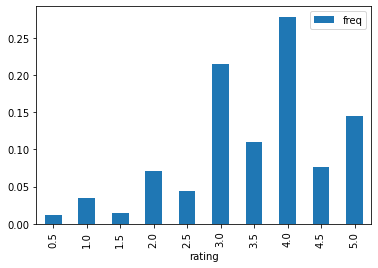

In [27]:
ratings_pd = pd.DataFrame(num_ratings_per_grade, columns=['rating', 'count'])
ratings_pd = ratings_pd.sort_values(by='rating').reset_index(drop=True)
ratings_pd['freq'] = ratings_pd['count'] / ratings_pd['count'].sum()
ratings_pd.plot.bar(x='rating', y='freq')

Half notes are not as common as full notes. Also users have a tendency to give good marks in general.

### Q4. Histogram of number of ratings per user

Plot the distribution of the number of movies rated per user. In other words, what is the fraction of users that rated between bins[i] and bins[i+1] movies for the following bins.  
What is the average and median number of ratings per user?

In [28]:
bins = np.unique(np.logspace(0, 160, base=1.05, num=50, dtype='int32'))
bins

array([   1,    2,    3,    4,    5,    6,    7,    9,   10,   12,   15,
         17,   20,   24,   28,   33,   39,   45,   53,   62,   73,   86,
        101,  119,  139,  163,  191,  225,  264,  309,  363,  425,  499,
        585,  686,  805,  944, 1107, 1298, 1523, 1786, 2094, 2456],
      dtype=int32)

In [29]:
def bucket_by(x):
    return np.digitize(x, bins)

In [30]:
num_ratings_per_user = ratings_rdd\
    .keyBy(lambda x: x['userId'])\
    .mapValues(lambda x: 1)\
    .reduceByKey(lambda x,y: x+y)

RDD we have defined above is lazy (no job is triggered). ReduceByKey function will provoke a shuffle.

In [31]:
ratings_hist = num_ratings_per_user\
    .keyBy(lambda x: bucket_by(x[1]))\
    .mapValues(lambda x: 1)\
    .reduceByKey(lambda x,y: x+y)\
    .collect()

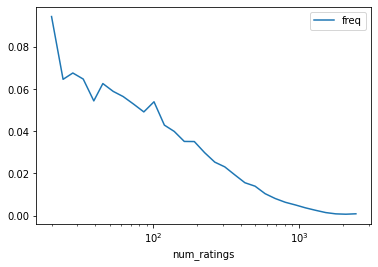

In [32]:
ratings_pd = pd.DataFrame(ratings_hist, columns=['bin_idx', 'count'])
ratings_pd = ratings_pd.sort_values(by='bin_idx').reset_index(drop=True)
ratings_pd['freq'] = ratings_pd['count'] / ratings_pd['count'].sum()
ratings_pd['num_ratings'] = ratings_pd['bin_idx'].apply(lambda x: bins[x-1])
ratings_pd.plot(x='num_ratings', y='freq', logx=True)

In [33]:
median_num_ratings = ratings_pd[ratings_pd['count'].cumsum() > ratings_pd['count'].sum() / 2].iloc[0]['num_ratings']
avg_num_ratings = (ratings_pd['num_ratings'] *  ratings_pd['count']).sum() / ratings_pd['count'].sum()
print(median_num_ratings)
print(avg_num_ratings)

62.0
133.38806293458876


### Q5. Most popular movies

What are the 20 movies with the most ratings ?  
We would like the answer with the movie title and not the movie id.  
Look at the documentation of the join and top functions.

In [34]:
num_ratings_per_movie = ratings_rdd\
    .keyBy(lambda x: x['movieId'])\
    .mapValues(lambda x: 1)\
    .reduceByKey(lambda x, y: x+y)

In [35]:
movies_title = movies_rdd.keyBy(lambda x: x['movieId']).mapValues(lambda x: x['title'])

ratings_with_title = num_ratings_per_movie\
    .join(movies_title)\
    .mapValues(lambda x: {'num_ratings': x[0], 'title': x[1]})\
    .values()

ratings_with_title.top(20, key=lambda x: x['num_ratings'])

[{'num_ratings': 67310, 'title': 'Pulp Fiction (1994)'},
 {'num_ratings': 66172, 'title': 'Forrest Gump (1994)'},
 {'num_ratings': 63366, 'title': 'Shawshank Redemption, The (1994)'},
 {'num_ratings': 63299, 'title': 'Silence of the Lambs, The (1991)'},
 {'num_ratings': 59715, 'title': 'Jurassic Park (1993)'},
 {'num_ratings': 54502, 'title': 'Star Wars: Episode IV - A New Hope (1977)'},
 {'num_ratings': 53769, 'title': 'Braveheart (1995)'},
 {'num_ratings': 52244, 'title': 'Terminator 2: Judgment Day (1991)'},
 {'num_ratings': 51334, 'title': 'Matrix, The (1999)'},
 {'num_ratings': 50054, 'title': "Schindler's List (1993)"},
 {'num_ratings': 49695, 'title': 'Toy Story (1995)'},
 {'num_ratings': 49581, 'title': 'Fugitive, The (1993)'},
 {'num_ratings': 47777, 'title': 'Apollo 13 (1995)'},
 {'num_ratings': 47048, 'title': 'Independence Day (a.k.a. ID4) (1996)'},
 {'num_ratings': 47006, 'title': 'Usual Suspects, The (1995)'},
 {'num_ratings': 46839,
  'title': 'Star Wars: Episode VI - Re

Because we know we don't work with a lots of records (20), a better option is to filter on top 20 before doing the join. The records will pass by the driver, but it's not a problem. Here is a first way of doing it.

In [36]:
top_movie_ids = num_ratings_per_movie.top(20, key=lambda x: x[1])

We can create an rdd from data materialized on the driver like this.

In [37]:
top_movie_ids_rdd = sc.parallelize(top_movie_ids)

In [38]:
top_movie_ids_rdd\
    .join(movies_title)\
    .mapValues(lambda x: x[1])\
    .values()\
    .collect()

['Shawshank Redemption, The (1994)',
 'Jurassic Park (1993)',
 'Matrix, The (1999)',
 'Apollo 13 (1995)',
 'Independence Day (a.k.a. ID4) (1996)',
 'Terminator 2: Judgment Day (1991)',
 'Toy Story (1995)',
 'Fugitive, The (1993)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Batman (1989)',
 'Pulp Fiction (1994)',
 'Forrest Gump (1994)',
 'Silence of the Lambs, The (1991)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Braveheart (1995)',
 "Schindler's List (1993)",
 'Usual Suspects, The (1995)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'American Beauty (1999)',
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']

When you wan to join and one RDD has not a lots of values, it is preferable to rely on broadcast join. Here is how to do it.

In [39]:
type(top_movie_ids[1])

tuple

In [40]:
top20_broadcast = sc.broadcast(dict(top_movie_ids))
def gen_rows(x):
  if x[0] in top20_broadcast.value:
    return [(top20_broadcast.value.get(x[0]), x)]
  else :
    return []
movies_title.flatMap(lambda x : gen_rows(x)).collect()

[(49695, (1, 'Toy Story (1995)')),
 (44980, (32, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)')),
 (47006, (50, 'Usual Suspects, The (1995)')),
 (53769, (110, 'Braveheart (1995)')),
 (47777, (150, 'Apollo 13 (1995)')),
 (54502, (260, 'Star Wars: Episode IV - A New Hope (1977)')),
 (67310, (296, 'Pulp Fiction (1994)')),
 (63366, (318, 'Shawshank Redemption, The (1994)')),
 (66172, (356, 'Forrest Gump (1994)')),
 (49581, (457, 'Fugitive, The (1993)')),
 (59715, (480, 'Jurassic Park (1993)')),
 (50054, (527, "Schindler's List (1993)")),
 (52244, (589, 'Terminator 2: Judgment Day (1991)')),
 (46054, (592, 'Batman (1989)')),
 (63299, (593, 'Silence of the Lambs, The (1991)')),
 (47048, (780, 'Independence Day (a.k.a. ID4) (1996)')),
 (45313, (1196, 'Star Wars: Episode V - The Empire Strikes Back (1980)')),
 (46839, (1210, 'Star Wars: Episode VI - Return of the Jedi (1983)')),
 (51334, (2571, 'Matrix, The (1999)')),
 (44987, (2858, 'American Beauty (1999)'))]

### Q6. Writing partioned datasets

The ratings dataset is available as one big csv file. It is not very convenient since we have to go through the entire file to look for ratings for a specific userId. Moreover, we cannot open only a small part of the dataset.  
Could you write the ratings dataset into 16 files located in /tmp/ratings/part=X/ratings.csv for X in [0, 16[ where userId in part=X are such that userId % 16 == X ?  Your function should return the list of written files with the number of ratings for each file.
Look at the documentation of partitionBy and mapPartitionsWithIndex.

In [41]:
help(ratings_rdd.mapPartitionsWithIndex)

Help on method mapPartitionsWithIndex in module pyspark.rdd:

mapPartitionsWithIndex(f, preservesPartitioning=False) method of pyspark.rdd.PipelinedRDD instance
    Return a new RDD by applying a function to each partition of this RDD,
    while tracking the index of the original partition.
    
    Examples
    --------
    >>> rdd = sc.parallelize([1, 2, 3, 4], 4)
    >>> def f(splitIndex, iterator): yield splitIndex
    >>> rdd.mapPartitionsWithIndex(f).sum()
    6



In [42]:
import os
basedir = 'partitioned_ratings'
os.mkdir(basedir)

def write_csv(part_num, ratings):
    partdir = f'{basedir}/part={part_num}'
    os.mkdir(partdir)
    filename = f'{partdir}/ratings.csv'
    with open(filename, 'w') as f:
        f.write('userId,movieId,rating,timestamp\n')
        num_ratings = 0
        for _, x in ratings:
            f.write(f"{x['userId']},{x['movieId']},{x['rating']},{x['timestamp']}\n")
            num_ratings += 1
    return [(filename, num_ratings)]

files_with_num_ratings = ratings_rdd\
    .keyBy(lambda x: x['userId'])\
    .partitionBy(16, partitionFunc=lambda x: x % 16)\
    .mapPartitionsWithIndex(write_csv)\
    .collect()
                    
files_with_num_ratings

[('partitioned_ratings/part=0/ratings.csv', 1226643),
 ('partitioned_ratings/part=1/ratings.csv', 1251582),
 ('partitioned_ratings/part=2/ratings.csv', 1290082),
 ('partitioned_ratings/part=3/ratings.csv', 1261058),
 ('partitioned_ratings/part=4/ratings.csv', 1244472),
 ('partitioned_ratings/part=5/ratings.csv', 1287006),
 ('partitioned_ratings/part=6/ratings.csv', 1252140),
 ('partitioned_ratings/part=7/ratings.csv', 1235974),
 ('partitioned_ratings/part=8/ratings.csv', 1258352),
 ('partitioned_ratings/part=9/ratings.csv', 1199879),
 ('partitioned_ratings/part=10/ratings.csv', 1245584),
 ('partitioned_ratings/part=11/ratings.csv', 1245817),
 ('partitioned_ratings/part=12/ratings.csv', 1244863),
 ('partitioned_ratings/part=13/ratings.csv', 1280600),
 ('partitioned_ratings/part=14/ratings.csv', 1219400),
 ('partitioned_ratings/part=15/ratings.csv', 1256811)]

### Q7. Most popular genre per year

For every year since 1980, determine what is the most popular genre.  
Look at the documentation of the flatMap function.

In [43]:
import re
year_pattern = re.compile(r"\((\d+)\)")
def extract_year(title):
    years = year_pattern.findall(title)
    return int(years[0]) if years else -1

In [44]:
movies_info = movies_rdd\
    .keyBy(lambda x: x['movieId'])\
    .mapValues(lambda x: {'year': extract_year(x['title']), 'genres': x['genres'].split('|')})\
    .filter(lambda x: x[1]['year'] >= 1900)

num_ratings_per_movie = ratings_rdd\
    .keyBy(lambda x: x['movieId'])\
    .mapValues(lambda x: 1)\
    .reduceByKey(lambda x,y: x+y)

ratings_per_movie_with_genre_year = num_ratings_per_movie\
    .join(movies_info)\
    .values()\
    .map(lambda x: {'num_ratings': x[0], **x[1]})

def explode_on_genre(movie_info):
    num_ratings = movie_info['num_ratings']
    year = movie_info['year']
    for genre in movie_info['genres']:
        yield {'year': year, 'num_ratings': num_ratings, 'genre': genre}

genre_year = ratings_per_movie_with_genre_year\
    .flatMap(explode_on_genre)\
    .keyBy(lambda x: (x['genre'], x['year']))\
    .mapValues(lambda x: x['num_ratings'])\
    .reduceByKey(lambda x,y: x+y)\
    .map(lambda x: (x[0][0], x[0][1], x[1]))\
    .collect()

Let's keep genres which are at-least most popular during one year.

In [45]:
genre_year_pd = pd.DataFrame(genre_year, columns=['genre', 'year', 'num_ratings'])
genre_year_pd = genre_year_pd[genre_year_pd['year']>=1980]

In [46]:
max_rating_per_year = genre_year_pd.groupby('year').agg({'num_ratings':'max'}).reset_index()
interesting_genres = set(max_rating_per_year.set_index(['year','num_ratings']).join(genre_year_pd.set_index(['year','num_ratings']))['genre'].unique())
interesting_genres

{'Action', 'Comedy', 'Drama'}

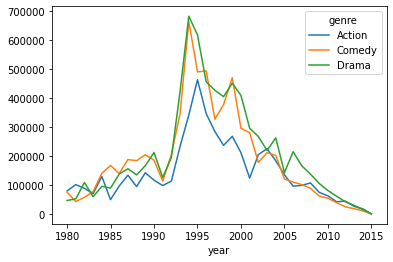

In [47]:
genre_year_pd = genre_year_pd[genre_year_pd['genre'].isin(interesting_genres)]
df = genre_year_pd.pivot(index='year', columns='genre', values='num_ratings')
df.plot()

### Q8.  Best movies

Amongst the movies with at least 1000 ratings, what are the top 20 movies per median rating ?

Computation of median can be done quickly there, as the set of ratings is discrete. We will define counters for each rating then it will be easy to compute median. Let's define some useful functions first.

In [ ]:
def collect_ratings(rating_counts):
    return {x['rating']: x['count'] for x in rating_counts}

def total_ratings(ratings):
    return sum(ratings.values())

def median_rating(ratings):
    target = total_ratings(ratings) / 2
    num_ratings = 0
    for rating in sorted(ratings.keys()):
        num_ratings += ratings[rating]
        if num_ratings >= target:
            return rating

First we need to know how many ratings of each kind we have for each movie. Then we can filter-out non popular movies before getting the top 20. We could join after calling 'top' also. Please note how Counter is great to accumulate values there.

In [ ]:
from collections import Counter

movie_rating_count = ratings_rdd\
    .keyBy(lambda x: x['movieId'])\
    .mapValues(lambda x: Counter({x['rating']:1}))\
    .reduceByKey(lambda x,y: x+y)\

median_rating_per_movie = movie_rating_count\
    .filter(lambda x: sum(x[1].values()) >= 1000)\
    .mapValues(median_rating)

median_rating_title = median_rating_per_movie\
    .join(movies_title)\
    .mapValues(lambda x: {'median_rating': x[0], 'title': x[1]})\
    .values()

median_rating_title.top(20, key=lambda x: x['median_rating'])

Out[47]: [{'median_rating': 5.0, 'title': 'Shawshank Redemption, The (1994)'},
 {'median_rating': 4.5, 'title': 'Intouchables (2011)'},
 {'median_rating': 4.5, 'title': 'Ikiru (1952)'},
 {'median_rating': 4.5, 'title': 'Persona (1966)'},
 {'median_rating': 4.5,
  'title': 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)'},
 {'median_rating': 4.5, 'title': 'Life Is Beautiful (La Vita è bella) (1997)'},
 {'median_rating': 4.5, 'title': 'Grand Illusion (La grande illusion) (1937)'},
 {'median_rating': 4.5,
  'title': 'Lord of the Rings: The Two Towers, The (2002)'},
 {'median_rating': 4.5, 'title': 'Casablanca (1942)'},
 {'median_rating': 4.5, 'title': 'Godfather, The (1972)'},
 {'median_rating': 4.5,
  'title': 'Seven Samurai (Shichinin no samurai) (1954)'},
 {'median_rating': 4.5,
  'title': 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'},
 {'median_rating': 4.5, 'title': 'Rear Window (1954)'},
 {'median_rating': 4.5, 'title': 'City of God (Cidade de 

In [ ]:
# # When you're done with a session you've created, stop it
spark.stop()